<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials,
                  match_all_differentials_and_tree)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp-v2'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
!ls -lhrt ../sfari/data/sra/Kang2017/week0_ogu

total 9.6G
-rw-rw-r-- 1 jmorton jmorton 5.8G Oct  8 11:37 differentials-v5.nc
-rw-rw-r-- 1 jmorton jmorton 2.0G Oct 25 01:00 differentials-v7.nc
-rw-rw-r-- 1 jmorton jmorton 2.0G Oct 28 23:28 differentials-v8.nc
-rw-rw-r-- 1 jmorton jmorton    0 Feb 14 11:53 slurm-1275786.out
drwxrwsr-x 2 jmorton jmorton    0 Feb 14 11:53 intermediate


In [3]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-simulated3.nc'
sim_diffs = extract_differentials(amp_fname)

amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
true_diffs = extract_differentials(amp_fname)

# load taxonomy
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

In [4]:
sim_diffs.index = true_diffs.index

Text(0, 0.5, 'Estimated mean log-fold change')

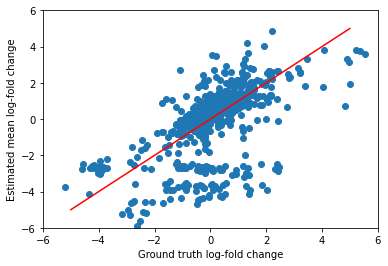

In [21]:
plt.scatter(true_diffs.mean(axis=1), sim_diffs.mean(axis=1), zorder=0)
plt.plot(np.linspace(-5, 5), np.linspace(-5, 5), 'r', zorder=1)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel('Ground truth log-fold change')
plt.ylabel('Estimated mean log-fold change')

Text(0, 0.5, 'Estimated log-fold change')

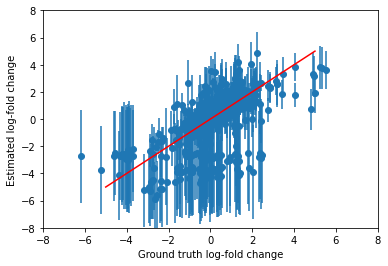

In [19]:
plt.errorbar(true_diffs.mean(axis=1), sim_diffs.mean(axis=1), yerr=sim_diffs.std(axis=1), 
             zorder=0, fmt='o')
plt.plot(np.linspace(-5, 5), np.linspace(-5, 5), 'r', zorder=1)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xlabel('Ground truth log-fold change')
plt.ylabel('Estimated log-fold change')

In [6]:
from scipy.stats import spearmanr
spearmanr(true_diffs.mean(axis=1), sim_diffs.mean(axis=1))

SpearmanrResult(correlation=0.6485174500524037, pvalue=6.468275014580531e-106)

Text(0, 0.5, 'Estimated log-fold change')

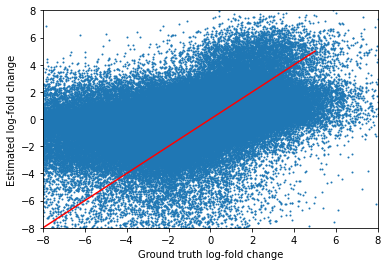

In [7]:
plt.scatter(sim_diffs.values.ravel(), true_diffs.values.ravel(), s=1)
plt.plot(np.linspace(-10, 5), np.linspace(-10, 5), 'r')
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xlabel('Ground truth log-fold change')
plt.ylabel('Estimated log-fold change')

In [8]:
spearmanr(sim_diffs.values.ravel(), true_diffs.values.ravel())

SpearmanrResult(correlation=0.47308588181688693, pvalue=0.0)

In [9]:
def rankplot(diffs, ax):
    lo = np.percentile(diffs.values, axis=1, q=5)
    hi = np.percentile(diffs.values, axis=1, q=95)
    index = np.arange(len(diffs))
    ax.fill_between(index, lo, hi, fc='b', label='Estimated')
    ax.set_ylabel('Log fold change')
    plt.xlabel('Microbes')

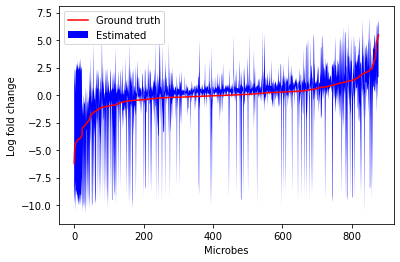

In [10]:
x = np.arange(len(sim_diffs))

ytrue = true_diffs.mean(axis=1)
ytrue = ytrue - ytrue.mean()
ytrue = ytrue.sort_values()

#sim_diffs = sim_diffs.loc[ytrue.index]
sim_diffs = sim_diffs - sim_diffs.mean(axis=0).values
yerr = sim_diffs.std(axis=1)

fig, ax = plt.subplots()
rankplot(sim_diffs.loc[ytrue.index], ax)
plt.plot(x, ytrue, '-', zorder=1, markersize=1, c='r', label='Ground truth')
plt.legend()
#y = sim_diffs.mean(axis=1)
#plt.errorbar(x, y, yerr=2*yerr, fmt="o", zorder=0, color='b')
#plt.plot(x, ytrue, 'o', zorder=1, markersize=1, c='r')
#plt.xlabel('Microbes')
#plt.ylabel('Log fold change')

In [22]:
table = biom.load_table('../sfari/data/sra/Combined/simulated3.biom')

In [23]:
totals = pd.Series(table.sum(axis='observation'), index=table.ids(axis='observation'))

Text(0, 0.5, 'Mean log fold change')

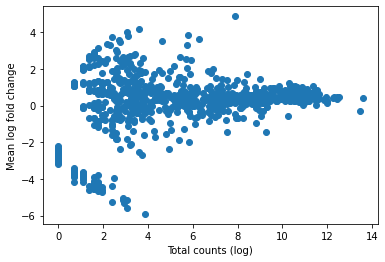

In [28]:
plt.scatter(np.log(totals + 1), sim_diffs.mean(axis=1))
plt.xlabel('Total counts (log)')
plt.ylabel('Mean log fold change')

Text(0, 0.5, 'Std dev log fold change')

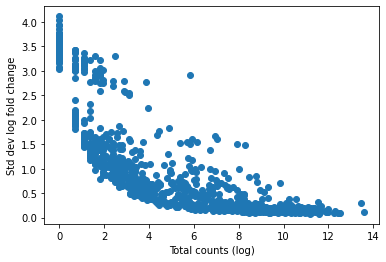

In [29]:
plt.scatter(np.log(totals + 1), sim_diffs.std(axis=1))
plt.xlabel('Total counts (log)')
plt.ylabel('Std dev log fold change')

Text(0.5, 0, 'Log fold change')

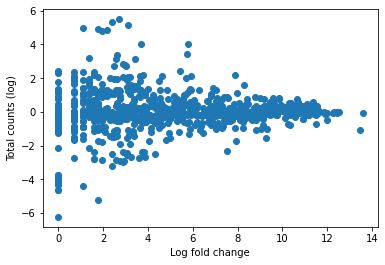

In [26]:
plt.scatter(np.log(totals + 1), ytrue.loc[sim_diffs.index])
plt.ylabel('Total counts (log)')
plt.xlabel('Log fold change')

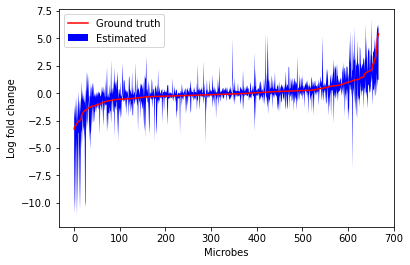

In [50]:
idx = totals.loc[np.log(totals + 1) > 2].index

ytrue = true_diffs.mean(axis=1).loc[idx]
ytrue = ytrue - ytrue.mean()
ytrue = ytrue.sort_values()

sim_diffs = sim_diffs.loc[ytrue.index]
sim_diffs = sim_diffs - sim_diffs.mean(axis=0).values
yerr = sim_diffs.std(axis=1)

x = np.arange(len(ytrue))

fig, ax = plt.subplots()
rankplot(sim_diffs, ax)
plt.plot(x, ytrue, '-', zorder=1, markersize=1, c='r', label='Ground truth')
plt.legend()
#y = sim_diffs.mean(axis=1)
#plt.errorbar(x, y, yerr=2*yerr, fmt="o", zorder=0, color='b')
#plt.plot(x, ytrue, 'o', zorder=1, markersize=1, c='r')
#plt.xlabel('Microbes')
#plt.ylabel('Log fold change')

In [49]:
ytrue

1262690   -3.270867
1262915   -3.056532
511       -3.009407
1746199   -2.993639
743973    -2.916016
             ...   
216142     3.935002
1301098    4.768346
1245471    5.097260
316        5.231935
160488     5.410978
Length: 668, dtype: float64

In [41]:
idx

Index(['1000569', '1002367', '1006000', '1007096', '1028307', '1033731',
       '1033732', '1033744', '1034345', '1034346',
       ...
       '938288', '964', '97138', '979556', '981334', '981539', '997894',
       '999411', '999413', '999419'],
      dtype='object', length=668)